In [22]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
import numpy as np

from sqlalchemy import create_engine
from sqlalchemy import text
import psycopg2
import psycopg2.extras
import json

from scipy.stats import zscore
import math

In [23]:
credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

Connect SQL

In [24]:
db, conn = pgconnect(credentials)

Connected successfully.


Open datasets

In [25]:
regions = gpd.read_file('SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp')
businesses = pd.read_csv('Businesses.csv')
stops = pd.read_csv('Stops.txt')
polls = pd.read_csv('PollingPlaces2019.csv')
school_future = gpd.read_file('catchments/catchments_future.shp')
school_primary = gpd.read_file('catchments/catchments_primary.shp')
school_secondary = gpd.read_file('catchments/catchments_secondary.shp')
population = pd.read_csv('Population.csv')
income = pd.read_csv('Income.csv')

Ensure every row in geometry is represented as multipolygons

In [26]:
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

srid = 4326
regions.dropna(inplace=True)
regions['geom'] = regions['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
regions = regions.drop(columns="geometry")  # deleting the old copy

school_future['geom'] = school_future['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
school_future = school_future.drop(columns="geometry")

school_primary['geom'] = school_primary['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
school_primary = school_primary.drop(columns="geometry")

school_secondary['geom'] = school_secondary['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
school_secondary = school_secondary.drop(columns="geometry")

Create a column 'geom' for stops

In [27]:
stops['geom'] = gpd.points_from_xy(stops.stop_lon, stops.stop_lat)
stops = stops.drop(columns=['stop_lat', 'stop_lon'])
stops['geom'] = stops['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))

In [28]:
polls.dropna(subset=['the_geom'], inplace=True)
polls['geom'] = gpd.points_from_xy(polls.longitude, polls.latitude)
polls['geom'] = polls['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
polls.drop(columns=['the_geom'], inplace=True)

Rename columns because some of the column names start with number or is uppercase

In [29]:
def col_converter_regions(col_names):
    col_dict = {}
    for c in col_names:
        new_c = c.lower() #convert every column name to lowercase
        if new_c[-2:] == '21': # if column names end with 21, remove it
            new_c = new_c[:-2]
        if new_c == 'loci_uri':
            new_c = 'url'
        col_dict[c] = new_c
    return col_dict

def col_converter_school(col_names):
    col_dict = {}
    for c in col_names:
        col_dict[c] = c.lower()
    return col_dict

col_names = regions.columns.values.tolist()
regions = regions.rename(columns=col_converter_regions(col_names))

col_names = school_future.columns.tolist()
school_future = school_future.rename(columns=col_converter_school(col_names))

col_names = school_primary.columns.tolist()
school_primary = school_primary.rename(columns=col_converter_school(col_names))

col_names = school_secondary.columns.tolist()
school_secondary = school_secondary.rename(columns=col_converter_school(col_names))

businesses = businesses.rename(columns={'0_to_50k_businesses':'b_0_to_50k', '50k_to_200k_businesses':'b_50k_to_200k', '200k_to_2m_businesses':'b_200k_to_2m'})
businesses = businesses.rename(columns={'2m_to_5m_businesses':'b_2m_to_5m', '5m_to_10m_businesses':'b_5m_to_10m', '10m_or_more_businesses':'b_10m_or_more'})

population = population.rename(columns={'0-4_people':'p_0_to_4', '5-9_people':'p_5_to_9', '10-14_people':'p_10_to_14', '15-19_people':'p_15_to_19'})
population = population.rename(columns={'20-24_people':'p_20_to_24', '25-29_people':'p_25_to_29', '30-34_people':'p_30_to_34', '35-39_people':'p_35_to_39'})
population = population.rename(columns={'40-44_people':'p_40_to_44', '45-49_people':'p_45_to_49', '50-54_people':'p_50_to_54', '55-59_people':'p_55_to_59'})
population = population.rename(columns={'60-64_people':'p_60_to_64', '65-69_people':'p_65_to_69', '70-74_people':'p_70_to_74', '75-79_people':'p_75_to_79'})
population = population.rename(columns={'80-84_people':'p_80_to_84', '85-and-over_people':'p_85_and_over'})

polls = polls.rename(columns={'FID':'fid'})


Replace some NA values

In [30]:
income = income.replace('np', None)

Create Schema

In [31]:
conn.execute(text("""
DROP TABLE IF EXISTS regions cascade;
CREATE TABLE regions (
    sa2_code VARCHAR(9),
    sa2_name VARCHAR(100),
    chg_flag CHAR,
    chg_lbl VARCHAR(20),
    sa3_code VARCHAR(5),
    sa3_name VARCHAR(100),
    sa4_code VARCHAR(3),
    sa4_name VARCHAR(100),
    gcc_code VARCHAR(5),
    gcc_name VARCHAR(100),
    ste_code CHAR,
    ste_name VARCHAR(100),
    aus_code VARCHAR(3),
    aus_name VARCHAR(100),
    areasqkm FLOAT,
    url VARCHAR(100),
    geom GEOMETRY(MULTIPOLYGON,4326)
);
"""))

conn.execute(text("""
DROP TABLE IF EXISTS businesses;
CREATE TABLE businesses (
    industry_code CHAR, 
    industry_name VARCHAR(100),
    sa2_code VARCHAR(9),
    sa2_name VARCHAR(100),
    b_0_to_50k INTEGER,
    b_50k_to_200k INTEGER,
    b_200k_to_2m INTEGER,
    b_2m_to_5m INTEGER,
    b_5m_to_10m INTEGER,
    b_10m_or_more INTEGER,
    total_businesses INTEGER
);
"""))
#b_0_to_50k is the number of businesses' income < 50k

conn.execute(text("""
DROP TABLE IF EXISTS stops;
CREATE TABLE stops (
    stop_id VARCHAR(10),
    stop_code VARCHAR(10),
    stop_name VARCHAR(100),
    location_type FLOAT,
    parent_station VARCHAR(10),
    wheelchair_boarding CHAR,
    platform_code VARCHAR(10),
    geom GEOMETRY(POINT, 4326)
);
"""))

conn.execute(text("""
DROP TABLE IF EXISTS polls;
CREATE TABLE polls (
    fid VARCHAR(100),
    state VARCHAR(3),
    division_id INTEGER,
    division_name VARCHAR(100),
    polling_place_id INTEGER,
    polling_place_type_id INTEGER,
    polling_place_name VARCHAR(100),
    premises_name VARCHAR(100),
    premises_address_1 VARCHAR(100),
    premises_address_2 VARCHAR(100),
    premises_address_3 VARCHAR(100),
    premises_suburb VARCHAR(100),
    premises_state_abbreviation VARCHAR(3),
    premises_post_code INTEGER,
    latitude FLOAT,
    longitude FLOAT,
    geom GEOMETRY(POINT,4326)
);
"""))

conn.execute(text("""
DROP TABLE IF EXISTS school_future;
CREATE TABLE school_future (
    use_id VARCHAR(4),
    catch_type VARCHAR(20),
    use_desc VARCHAR(100),
    add_date INTEGER,
    kindergart INTEGER,
    year1 INTEGER,
    year2 INTEGER,
    year3 INTEGER,
    year4 INTEGER,
    year5 INTEGER,
    year6 INTEGER,
    year7 INTEGER,
    year8 INTEGER,
    year9 INTEGER,
    year10 INTEGER,
    year11 INTEGER,
    year12 INTEGER,
    geom GEOMETRY(MULTIPOLYGON,4326)
);
"""))

conn.execute(text("""
DROP TABLE IF EXISTS school_primary;
CREATE TABLE school_primary (
    use_id VARCHAR(4),
    catch_type VARCHAR(20),
    use_desc VARCHAR(100),
    add_date INTEGER,
    kindergart CHAR,
    year1 CHAR,
    year2 CHAR,
    year3 CHAR,
    year4 CHAR,
    year5 CHAR,
    year6 CHAR,
    year7 CHAR,
    year8 CHAR,
    year9 CHAR,
    year10 CHAR,
    year11 CHAR,
    year12 CHAR,
    priority CHAR,
    geom GEOMETRY(MULTIPOLYGON,4326)
);
"""))

conn.execute(text("""
DROP TABLE IF EXISTS school_secondary;
CREATE TABLE school_secondary (
    use_id VARCHAR(4),
    catch_type VARCHAR(20),
    use_desc VARCHAR(100),
    add_date INTEGER,
    kindergart CHAR,
    year1 CHAR,
    year2 CHAR,
    year3 CHAR,
    year4 CHAR,
    year5 CHAR,
    year6 CHAR,
    year7 CHAR,
    year8 CHAR,
    year9 CHAR,
    year10 CHAR,
    year11 CHAR,
    year12 CHAR,
    priority CHAR,
    geom GEOMETRY(MULTIPOLYGON,4326)
);
"""))

conn.execute(text("""
DROP TABLE IF EXISTS population;
CREATE TABLE population (
    sa2_code VARCHAR(9),
    sa2_name VARCHAR(100),
    p_0_to_4 INTEGER,
    p_5_to_9 INTEGER,
    p_10_to_14 INTEGER,
    p_15_to_19 INTEGER,
    p_20_to_24 INTEGER,
    p_25_to_29 INTEGER,
    p_30_to_34 INTEGER,
    p_35_to_39 INTEGER,
    p_40_to_44 INTEGER,
    p_45_to_49 INTEGER,
    p_50_to_54 INTEGER,
    p_55_to_59 INTEGER,
    p_60_to_64 INTEGER,
    p_65_to_69 INTEGER,
    p_70_to_74 INTEGER,
    p_75_to_79 INTEGER,
    p_80_to_84 INTEGER,
    p_85_and_over INTEGER,
    total_people INTEGER
);
"""))
#p_0_to_4 is the number of people age from 0 to 4

conn.execute(text("""
DROP TABLE IF EXISTS income;
CREATE TABLE income (
    sa2_code VARCHAR(9),
    sa2_name VARCHAR(100),
    earners INTEGER,
    median_age INTEGER,
    median_income INTEGER,
    mean_income INTEGER
);
"""))

Importing dataframes to sql

In [32]:
regions.to_sql('regions', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
businesses.to_sql('businesses', conn, if_exists='append', index=False)
stops.to_sql('stops', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
polls.to_sql('polls', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
school_future.to_sql('school_future', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
school_primary.to_sql('school_primary', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
school_secondary.to_sql('school_secondary', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
population.to_sql('population', conn, if_exists='append', index=False)
income.to_sql('income', conn, if_exists='append', index=False)

576

Get investigatable regions, young people per region, total people per region:

In [33]:
result = query(conn, text(""" 
    SELECT sa2_name, (p_0_to_4 + p_5_to_9 + p_10_to_14 + p_15_to_19) as young_people, total_people
    FROM population
"""))

regions_arr = []
region_to_young = dict()
region_to_people = dict()
for i, row in result.iterrows():
    name, young, total = row.values
    if young > 100 and total > 100:
        regions_arr.append(name)
        try:
            young = int(young)
            if young != 0:
                region_to_young[name] = young
        except ValueError as e:
            continue
        try:
            total = int(total)
            if total != 0:
                region_to_people[name] = total
        except ValueError as e:
            continue

print(len(regions_arr))

359


Retail:

In [34]:
result = query(conn, text(""" 
    SELECT sa2_name, total_businesses
    FROM businesses
    WHERE industry_name = 'Retail Trade'
    ORDER BY total_businesses DESC
"""))

retail_dict = dict.fromkeys(regions_arr, 0)
for i, row in result.iterrows():
    name, total = row.values
    total = int(total)
    retail_dict[name] = total

retail_per_thousand = dict.fromkeys(regions_arr, 0)
for key in retail_dict.keys():
    try:
        num = (retail_dict[key] / region_to_people[key])*1000
        retail_per_thousand[key] = num
    except KeyError:
        continue

retail_per_thousand = dict(sorted(retail_per_thousand.items(), key=lambda x: x[1], reverse=True))

zscores = zscore(list(retail_per_thousand.values()))
retail_zscores = dict(zip(retail_per_thousand.keys(), zscores))

print(len(retail_zscores))

359


Health:

In [35]:
result = query(conn, text(""" 
    SELECT sa2_name, total_businesses
    FROM businesses
    WHERE industry_name = 'Health Care and Social Assistance'
    ORDER BY total_businesses DESC
"""))

health_dict = dict.fromkeys(regions_arr, 0)
for i, row in result.iterrows():
    name, total = row.values
    total = int(total)
    health_dict[name] = total

health_per_thousand = dict()
for key in health_dict.keys():
    try:
        num = (health_dict[key] / region_to_people[key])*1000
        health_per_thousand[key] = num
    except KeyError:
        continue
    
health_per_thousand = dict(sorted(health_per_thousand.items(), key=lambda x: x[1], reverse=True))

zscores = zscore(list(health_per_thousand.values()))
health_zscores = dict(zip(health_per_thousand.keys(), zscores))
    
print(len(health_zscores))

359


Index regions and stops for fast JOIN:

In [36]:
conn.execute(text("""
    DROP INDEX IF EXISTS geom_idx_regions;
    CREATE INDEX geom_idx_regions ON regions USING GIST(geom);
"""));
conn.execute(text("""
    DROP INDEX IF EXISTS geom_idx_stops;
    CREATE INDEX geom_idx_stops ON regions USING GIST(geom);
"""));

Stops:

In [37]:
result = query(conn, text("""
    SELECT r.sa2_name, COUNT(*) 
    FROM regions r
        JOIN stops s ON ST_Contains(r.geom, s.geom)
    GROUP BY r.sa2_name
    ORDER BY count DESC
"""))

stops_per_region = dict.fromkeys(regions_arr, 0)
for i, row in result.iterrows():
    region, count = row.values
    if region in regions_arr:
        stops_per_region[region] = count
    
zscores = zscore(list(stops_per_region.values()))
stops_zscores = dict(zip(stops_per_region.keys(), zscores))

print(len(stops_zscores))

359


Polls:

In [38]:
result = query(conn, text("""
    SELECT r.sa2_name, COUNT(*) 
    FROM regions r
        JOIN polls p ON ST_Contains(r.geom, p.geom)
    GROUP BY r.sa2_name
    ORDER BY count DESC
"""))

polls_per_region = dict.fromkeys(regions_arr, 0)
for i, row in result.iterrows():
    region, count = row.values
    if region in regions_arr:
        polls_per_region[region] = count

zscores = zscore(list(polls_per_region.values()))
polls_zscores = dict(zip(polls_per_region.keys(), zscores))

print(len(polls_zscores))

359


In [39]:
conn.execute(text("""
    DROP INDEX IF EXISTS geom_idx_primary;
    CREATE INDEX geom_idx_primary ON school_primary USING GIST(geom);
"""));
conn.execute(text("""
    DROP INDEX IF EXISTS geom_idx_secondary;
    CREATE INDEX geom_idx_secondary ON school_secondary USING GIST(geom);
"""));
conn.execute(text("""
    DROP INDEX IF EXISTS geom_idx_future;
    CREATE INDEX geom_idx_future ON school_future USING GIST(geom);
"""));

In [40]:
result = query(conn, text("""
    SELECT r.sa2_name, COUNT(*)
    FROM regions r
        JOIN school_primary s ON ST_Intersects(r.geom, s.geom)
    GROUP BY sa2_name
    ORDER BY count DESC
"""))

schools_per_region = dict.fromkeys(regions_arr, 0)
for i, row in result.iterrows():
    region, count = row.values
    if region in regions_arr:
        schools_per_region[region] = count

result = query(conn, text("""
    SELECT r.sa2_name, COUNT(*)
    FROM regions r
        JOIN school_secondary s ON ST_Intersects(r.geom, s.geom)
    GROUP BY sa2_name
    ORDER BY count DESC
"""))

for i, row in result.iterrows():
    region, count = row.values
    if region in regions_arr:
        schools_per_region[region] += count

result = query(conn, text("""
    SELECT r.sa2_name, COUNT(*)
    FROM regions r
        JOIN school_future s ON ST_Intersects(r.geom, s.geom)
    GROUP BY sa2_name
    ORDER BY count DESC
"""))

for i, row in result.iterrows():
    region, count = row.values
    if region in regions_arr:
        schools_per_region[region] += count
        
zscores = zscore(list(schools_per_region.values()))
schools_zscores = dict(zip(schools_per_region.keys(), zscores))

print(len(schools_zscores))

359


Calculate Score:

In [41]:
scores = dict()
for region in regions_arr:
    sum = 0
    try:
        sum += retail_zscores.get(region)
        sum += health_zscores.get(region)
        sum += stops_zscores.get(region)
        sum += polls_zscores.get(region)
        sum += schools_zscores.get(region)
    except TypeError as e:
        print(e)
        continue
    scores[region] = 1 / (1 + math.exp(-sum))

print(len(scores))

359


Car crash in NSW

In [42]:
crash = pd.read_excel('car_crash.xlsx')

Kepp specific columns

In [43]:
crash = crash[['Degree of crash', 'Year of crash', 'Month of crash', 'Day of week of crash', 'Latitude', 'Longitude', 'Weather']]

Create geom columns

In [44]:
crash.dropna(inplace=True)
crash['geom'] = gpd.points_from_xy(crash.Longitude, crash.Latitude)
crash = crash.drop(columns=['Longitude', 'Latitude'])
crash['geom'] = crash['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))

Convert columns to lowercase

In [45]:
col_dict = {}
for c in crash.columns:
    col_dict[c] = c.lower()
    keyword = c.split(' ')[0]
    if keyword in ['Degree', 'Year', 'Month', 'Day']:
        col_dict[c] = keyword.lower()
crash.rename(columns=col_dict, inplace=True)

Create schema

In [46]:
conn.execute(text("""
DROP TABLE IF EXISTS crash;
CREATE TABLE crash (
    degree VARCHAR(100),
    year INT,
    month VARCHAR(20),
    day VARCHAR(15),
    weather VARCHAR(50),
    geom GEOMETRY(POINT, 4326)
);
"""));

In [47]:
crash.to_sql('crash', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})

718

In [48]:
result = query(conn, text("""
    SELECT r.sa2_name, COUNT(*) 
    FROM regions r
        JOIN crash c ON ST_Contains(r.geom, c.geom)
    GROUP BY r.sa2_name
    ORDER BY count(*) DESC
"""))

crash_per_region = dict.fromkeys(regions_arr, 0)
for i, row in result.iterrows():
    region, count = row.values
    if region in regions_arr:
        crash_per_region[region] = count
    
zscores = zscore(list(crash_per_region.values()))
crash_zscores = dict(zip(crash_per_region.keys(), zscores))
print(len(crash_zscores))

359


In [49]:
crime = pd.read_csv("crime_rate")

Keep specific columns

In [50]:
crime = crime[['bcsrgrp', 'locsurb', 'locpcode', 'bcsrgclat', 'bcsrgclng', 'incyear', 'incmonth', 'incday']]

Create geom column

In [51]:
crime.dropna(subset=['bcsrgclat', 'bcsrgclng'], inplace=True)
crime['geom'] = gpd.points_from_xy(crime.bcsrgclng, crime.bcsrgclat)
crime = crime.drop(columns=['bcsrgclng', 'bcsrgclat'])
crime['geom'] = crime['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))

Create schema

In [52]:
conn.execute(text("""
DROP TABLE IF EXISTS crime;
CREATE TABLE crime (
    bcsrgrp VARCHAR(100),
    locsurb VARCHAR(100), 
    locpcode INT,
    incyear INT,
    incmonth VARCHAR(15),
    incday VARCHAR(10),
    geom GEOMETRY(POINT, 4326)
);
"""));

In [53]:
crime.to_sql('crime', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})

605

In [54]:
result = query(conn, text("""
    SELECT r.sa2_name, COUNT(*) 
    FROM regions r
        JOIN crime c ON ST_Contains(r.geom, c.geom)
    GROUP BY r.sa2_name
    ORDER BY count(*) DESC
"""))

crime_per_region = dict.fromkeys(regions_arr, 0)
for i, row in result.iterrows():
    region, count = row.values
    if region in regions_arr:
        crime_per_region[region] = count
    
zscores = zscore(list(crime_per_region.values()))
crime_zscores = dict(zip(crime_per_region.keys(), zscores))
print(len(crime_zscores))

359


New Scores:

In [55]:
new_scores = dict()
for region in regions_arr:
    sum = 0
    try:
        sum += retail_zscores.get(region)
        sum += health_zscores.get(region)
        sum += stops_zscores.get(region)
        sum += polls_zscores.get(region)
        sum += schools_zscores.get(region)
        sum += crash_zscores.get(region)
        sum += crime_zscores.get(region)
    except TypeError as e:
        print(e)
        continue
    new_scores[region] = 1 / (1 + math.exp(-sum))

print(len(new_scores))

359


Graph for New Scores:

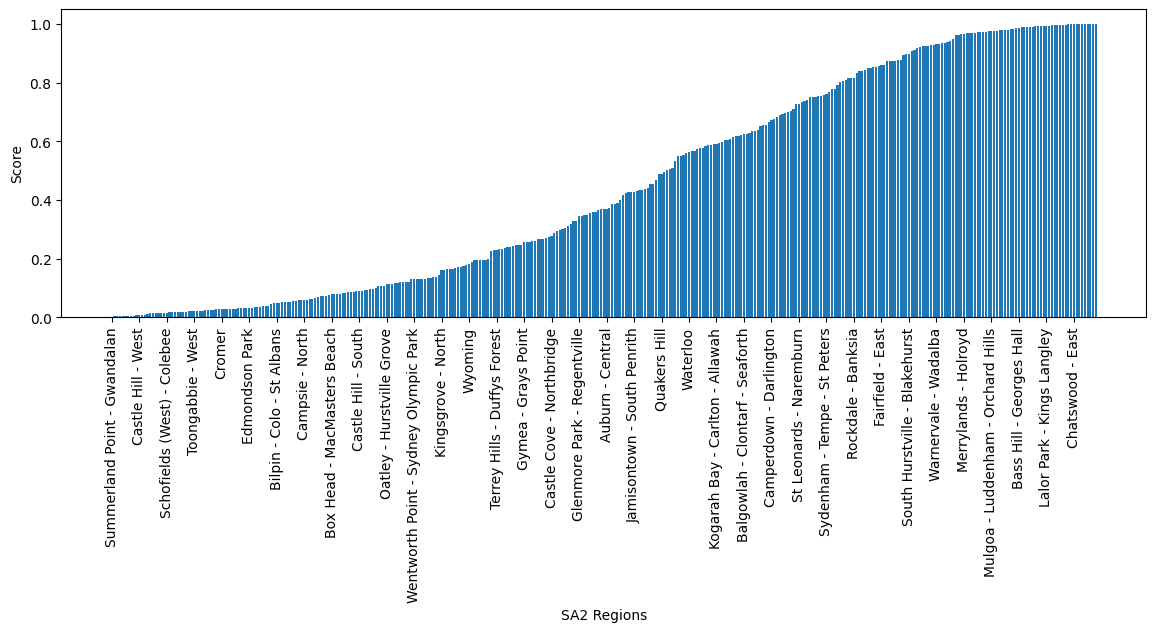

In [72]:
sorted_scores = dict(sorted(new_scores.items(), key=lambda x: x[1]))

x = list(sorted_scores.keys())
y = list(sorted_scores.values())

plt.figure(figsize=[14, 4])
plt.bar(x, y)

tick_locations = np.arange(0, len(x), 10)
tick_labels = [x[loc] for loc in tick_locations]
plt.xticks(tick_locations, tick_labels)

plt.xlabel('SA2 Regions')
plt.ylabel('Score')
plt.xticks(rotation=90)

plt.show()

Income vs. Score Correlation:

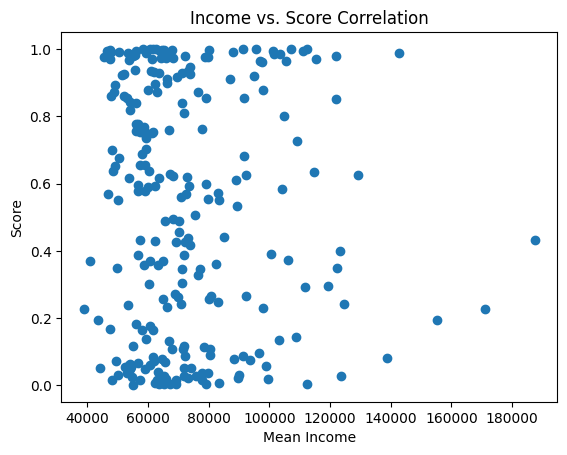

In [81]:
result = query(conn, text("""
    SELECT sa2_name, mean_income
    FROM income
    ORDER BY mean_income DESC
"""))
income_dict = dict.fromkeys(regions_arr, 0)
for i, row in result.iterrows():
    region, income = row.values
    if region in regions_arr:
        income_dict[region] = income

x = []
y = []
for region in income_dict.keys():
    if income_dict.get(region) != 0:
        x.append(income_dict.get(region))
        y.append(new_scores.get(region))
        
plt.scatter(x, y)

plt.xlabel('Average Income')
plt.ylabel('Score')
plt.title('Income vs. Score Correlation')

plt.show()